# Capstone project

## A client has an Italian restaurant in São Paulo, SP, Brasil, and he wants to open a second unit of the restaurant in the city. His restaurant is located in Pinheiros district, has a price tier 3 (FourSquare standards) and rating 8.9. In my project, I will recommend where he should open the second unit of his restaurant.

### There are considerable socioeconomics differences between São Paulo neighborhoods. Thus, in the first step of my project I will gather socioeconomics informations about each district of São Paulo and cluster them. The new unit of the restaurant should be in a district with similar socioeconomics characteristics of Pinheiros, because his restaurant showed to be adequate to this district characteristics.

Importing libs

In [163]:
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing

import folium # map rendering library

In Wikipedia, there is a list of São Paulo districts, I will open and parse this page and get every district name and page on Wiki

In [27]:
#typing the Wikipedia url
url = "https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o"

In [28]:
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html,'lxml')

In [29]:
#now I find every table body in my soup
s = (soup.find_all("tbody"))
#the table of my interest is the first here
table = s[0]

Getting districts page links

In [30]:
districtLinks = []
for a in table.find_all('a', href=True):
    districtLinks.append("https://pt.wikipedia.org" + a['href'])

And getting districts names

In [31]:
districtNames = []
for a in table.find_all('a', title=True):
    districtNames.append(a['title'])

Now, I open every district page. In most of them, there are two importants socioeconomics infos, the GDP per capita and HDI, that I will get from each page.

In [34]:
income = []
HDI = []

for url in districtLinks:
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html,'lxml')
    
    s = (soup.find_all("tbody"))
    #the table of my interest is the first here
    table = s[0]
    incomeNeigh = '-'
    HDIneigh = '-'
    
    for i in table.find_all('td'):
        try:
            if i.contents[0].startswith("R$"):
                incomeNeigh = i.contents[0]
        except:
            pass
        
        try:
            if i.contents[0].startswith("0,"):
                HDIneigh = i.contents[0]
        except:
            pass
        
    income.append(incomeNeigh)
    HDI.append(HDIneigh)
    

In [35]:
print(income)

['R$ 2.500,00\n', 'R$ 3.041,40\n', 'R$ 1.700,00\n', '-', '-', '-', 'R$ 5.500,00\n', '-', '-', '-', '-', 'R$ 1 745,78\n', '-', 'R$ 4,200,00\n', 'R$ 1.058,87\n', 'R$ 1.120,66\n', 'R$ 543,58\n', '-', 'R$ 4.200.00\n', 'R$ 653,78\n', '-', '-', 'R$ 874,21\n', 'R$ 870,00\n', '-', '-', '-', '-', '-', 'R$ 897,11\n', 'R$ 894,53 ', '-', '-', 'R$ 822,70\n', '-', 'R$ 7.000,00\n', 'R$ 2.507,75\n', 'R$ 1 058,87\n', 'R$ 8.000,00\n', 'R$ 807,88\n', 'R$ 1.014,48\n', '-', '-', '-', 'R$ 1.160,95\n', 'R$ 6.746,86\n', 'R$ 968,03\n', '-', 'R$ 1.345,63\n', '-', 'R$ 919,10\n', '-', 'R$ 3.698,75\n', 'R$ 1.818,50\n', 'R$ 1.776,56\n', 'R$ 1.279,40\n', '-', 'R$ 3.755,40\n', 'R$ 2 836,56\n', 'R$ 650,36\n', '-', 'R$ 5.500,23\n', 'R$ 2.503,34\n', 'R$ 5.144,03\n', 'R$ 1.411.67\n', 'R$ 3.661,96\n', 'R$ 12.428 ', 'R$ 2.948,70\n', 'R$ 2.200,18\n', 'R$ 2.505,76\n', 'R$ 4.098,75\n', 'R$ 6.000,00\n', 'R$ 7.000,00\n', 'R$ 6.000,00\n', 'R$ 5.000,00\n', 'R$ 2.333,84\n', 'R$ 2.435,70\n', '-', 'R$ 1.393,41\n', 'R$ 2 584,46\n', '

In [36]:
print(HDI)

['0,754 - ', '0,786 - ', '0,750 - ', '0,769 - ', '-', '-', '0,801 - ', '0,762 - ', '-', '-', '-', '0,806 - ', '-', '0,815 - ', '0,795 - ', '0,826 - ', '0,748 - ', '-', '0,904 - ', '0,765 - ', '-', '-', '0,802 - ', '0,751 - ', '-', '-', '-', '0,850 - ', '-', '0,817 - ', '0,836 - ', '0,779 - ', '-', '0,801 - ', '0,855 - ', '0,950 - ', '0,925 - ', '0,770 - ', '0,942 - ', '0,804 - ', '0,824 - ', '-', '-', '-', '0,864 - ', '0,957 - ', '0,819 - ', '0,921 - ', '0,867 - ', '-', '0,834 - ', '-', '0,879- ', '0,885 - ', '0,816 - ', '0,854 - ', '-', '0,884 - ', '0,923 - ', '0,772 - ', '-', '0,953 - ', '0,886 - ', '0,957 - ', '0,874 - ', '0,936 - ', '0,981 - ', '0,886 - ', '0,859 - ', '0,930 - ', '0,909 - ', '0,935 - ', '0,960 - ', '0,943 - ', '0,941 - ', '0,858 - ', '0,940 - ', '0,774 - ', '0,868 - ', '0,928 - ', '0,950 - ', '-', '0,849 - ', '0,955 - ', '0,841 - ', '-', '0,938 - ', '0,907 - ', '0,903 - ', '0,847 - ', '0,868 - ', '0,863 - ', '0,858 - ', '-', '-', '-']


And now I create a dataframe with every district name, GDP per capita and HDI. The GDP per capita is given in Brazilian currency (real), in which 1 dollar = 3.80 reais (approx. in Jan/2019)

In [37]:
d = {'District': districtNames, 'GDP per capita': income, 'HDI' : HDI}
df_sp = pd.DataFrame(data = d)
df_sp.head()

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),"R$ 2.500,00","0,754 -"
1,Sapopemba,"R$ 3.041,40","0,786 -"
2,Jardim Ângela,"R$ 1.700,00","0,750 -"
3,Brasilândia (distrito de São Paulo),-,"0,769 -"
4,Capão Redondo,-,-


This data is a little bit messy, so I need to clean it up in order to apply the cluster technique

In [38]:
df_sp["GDP per capita"] = df_sp["GDP per capita"].map(lambda x: x.lstrip('R$ ').rstrip('\n'))
df_sp.head()

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),"2.500,00","0,754 -"
1,Sapopemba,"3.041,40","0,786 -"
2,Jardim Ângela,"1.700,00","0,750 -"
3,Brasilândia (distrito de São Paulo),-,"0,769 -"
4,Capão Redondo,-,-


In Brazilian Portuguese, the standards dictate that the decimals are separated by comma and dots are used to distinguish thousands, millions, billions etc...
I need to put these strings in such a way they can be converted to float later.

In [39]:
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace("\.","")
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace(",",".")
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace(" ","")
df_sp.head()

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),2500.00,"0,754 -"
1,Sapopemba,3041.40,"0,786 -"
2,Jardim Ângela,1700.00,"0,750 -"
3,Brasilândia (distrito de São Paulo),-,"0,769 -"
4,Capão Redondo,-,-


In [40]:
df_sp["HDI"] = df_sp["HDI"].str.replace(" - ","")
df_sp["HDI"] = df_sp["HDI"].str.replace(",",".")
df_sp.head()

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),2500.00,0.754
1,Sapopemba,3041.40,0.786
2,Jardim Ângela,1700.00,0.750
3,Brasilândia (distrito de São Paulo),-,0.769
4,Capão Redondo,-,-


The districts that do not contain GDP or HDI must be discarded, because they cannot be clustered, unfortunately.

In [41]:
df_sp = df_sp.loc[df_sp["GDP per capita"] != '-']
df_sp = df_sp.loc[df_sp["HDI"] != '-']
df_sp

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),2500.00,0.754
1,Sapopemba,3041.40,0.786
2,Jardim Ângela,1700.00,0.750
6,Cidade Ademar,5500.00,0.801
11,Campo Limpo (distrito de São Paulo),1745.78,0.806
13,Cidade Dutra,4.200.00,0.815
14,Itaquera,1058.87,0.795
15,Tremembé (distrito de São Paulo),1120.66,0.826
16,Lajeado (distrito de São Paulo),543.58,0.748
18,Pirituba,420000,0.904


Most of the districts have GDP and HDI, which is good. But there are some weird values in the dataframe. I checked on Wiki and made the corrections here.

In [42]:
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace("4.200.00","4200.00")
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace("420000","4200.00")
df_sp["GDP per capita"] = df_sp["GDP per capita"].str.replace("141167","1411.67")
df_sp["HDI"] = df_sp["HDI"].str.replace("-","")

Now, I convert the indicators to float

In [43]:
df_sp["GDP per capita"] = pd.to_numeric(df_sp["GDP per capita"])
df_sp["HDI"] = pd.to_numeric(df_sp["HDI"])
df_sp

,District,GDP per capita,HDI
0,Grajaú (distrito de São Paulo),2500.00,0.754
1,Sapopemba,3041.40,0.786
2,Jardim Ângela,1700.00,0.750
6,Cidade Ademar,5500.00,0.801
11,Campo Limpo (distrito de São Paulo),1745.78,0.806
13,Cidade Dutra,4200.00,0.815
14,Itaquera,1058.87,0.795
15,Tremembé (distrito de São Paulo),1120.66,0.826
16,Lajeado (distrito de São Paulo),543.58,0.748
18,Pirituba,4200.00,0.904


Now I will scatter plot my data to have an idea of how many clusters I will use...

Text(0, 0.5, 'HDI')

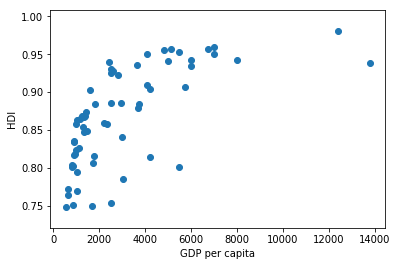

In [176]:
import matplotlib.pyplot as plt

plt.scatter(df_sp["GDP per capita"],df_sp["HDI"])
plt.xlabel("GDP per capita")
plt.ylabel("HDI")

And before using K-means, I must normalize my data

In [45]:
x = df_sp[["GDP per capita","HDI"]] #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_spCluster = pd.DataFrame(x_scaled)
df_spCluster.head()

,0,1
0,0.147561,0.025751
1,0.188395,0.163090
2,0.087222,0.008584
3,0.373832,0.227468
4,0.090674,0.248927


Well, in my scatter plot, data is not that separated. If I use 4 or 5 clusters, maybe districts that are not that similar might be clustered together, so I will try with 7 clusters.

Text(0, 0.5, 'HDI')

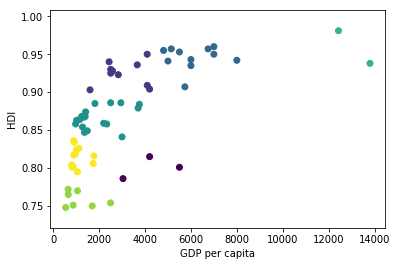

In [46]:
kclusters = 7

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_spCluster)

pd.set_option('display.max_row', 100)

df_sp["Cluster ID"] = kmeans.labels_
df_sp.sort_values(by=["Cluster ID"])

plt.scatter(df_sp["GDP per capita"],df_sp["HDI"],c=kmeans.labels_.astype(float))
plt.xlabel("GDP per capita")
plt.ylabel("HDI")

This result seems good by the clustered scatter plot... Let me check the dataframe.

In [177]:
df_sp

,District,GDP per capita,HDI,Cluster ID
0,Grajaú (distrito de São Paulo),2500.00,0.754,5
1,Sapopemba,3041.40,0.786,0
2,Jardim Ângela,1700.00,0.750,5
6,Cidade Ademar,5500.00,0.801,0
11,Campo Limpo (distrito de São Paulo),1745.78,0.806,6
13,Cidade Dutra,4200.00,0.815,0
14,Itaquera,1058.87,0.795,6
15,Tremembé (distrito de São Paulo),1120.66,0.826,6
16,Lajeado (distrito de São Paulo),543.58,0.748,5
18,Pirituba,4200.00,0.904,1


Pinheiros (where my client's restaurant is located), is placed in cluster 2, so I will create a dataframe with every district placed in cluster 2.

In [48]:
df_pinh = df_sp.loc[df_sp["Cluster ID"] == 2]
df_pinh = df_pinh[['District','GDP per capita','HDI']]
df_pinh.index = np.linspace(0,df_pinh.shape[0]-1,num=df_pinh.shape[0]).astype(int)
df_pinh

,District,GDP per capita,HDI
0,Vila Mariana (distrito de São Paulo),7000.00,0.950
1,Saúde (distrito de São Paulo),8000.00,0.942
2,Perdizes (distrito de São Paulo),6746.86,0.957
3,Itaim Bibi,5500.23,0.953
4,Jardim Paulista (distrito de São Paulo),5144.03,0.957
5,Campo Belo (distrito de São Paulo),6000.00,0.935
6,Pinheiros (distrito de São Paulo),7000.00,0.960
7,Santo Amaro (distrito de São Paulo),6000.00,0.943
8,Lapa (distrito de São Paulo),5000.00,0.941
9,Alto de Pinheiros,4809.46,0.955


Looks good, similar GDP per capita and HDI! Now I must continue my analysis.

### Now I have a set of districts with similar characteristics when compared to Pinheiros. Thereby, I must choose which one(s) of them is the best to place the second unit of his restaurant. I will get every Italian restaurant and pizzeria of these neighborhoods to analyze the competition that my client would face in each neighborhood. In Brasil, many Italian restaurants have pizzas and many pizza places have Italian dishes, so I need to analyze both categories.

The first step of this analysis is getting the coordinates of each district. But there is a problem, I had not good results with geocoder here. So I had to figure another way to get these values. I found a web site that gives these coordinates. So I will search on google each district, get the url of this site and parse it in order to get the latitude and longitude.

Installing google search lib...

In [49]:
import sys
#!{sys.executable} -m pip install git+https://github.com/abenassi/Google-Search-API
#!{sys.executable} -m pip install google-search
!{sys.executable} -m pip install google
#!{sys.executable} -m pip install pygeocoder
#!{sys.executable} -m pip install geocoder

  Running setup.py bdist_wheel for google ... done
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/b3/6d/94/ad59f018e26ad1987116a8eda758a4dd4285fcb0b4daf7c50d
Successfully built google


Now I search the url for each district. The web site of my interest contains 'adistanciaentre' (the distance between) and calculates lat long, distance between 2 points and other features. In one search, google returned lat long and distance results, so I discarded distance results in my if.

In [50]:
from googlesearch import search

url = []
for district in df_pinh['District']:
    string = district + " lat long"
    links = search(string, stop=20)
    for link in links:
        if "adistanciaentre" in link and "distancia-entre-" not in link:
            url.append(link)
            break

Now I parse the site and get latitude and longitude of each neighborhood. The okFlag verifies if longitude is gotten. And after I manipulate my results in order to convert to float (once again, Brazilian standards for numbers...)

In [51]:
lat = []
long = []
okFlag = False

for site in url:
    html = urllib.request.urlopen(site).read()
    soup = BeautifulSoup(html,'lxml')
    okFlag = False
    for v in soup.find_all('span', itemprop="Latitude"):
        lat.append(v.contents[0])
    for w in soup.find_all('span', itemprop="Longitude"):
        long.append(w.contents[0])
        okFlag = True
    print(okFlag)

lat = [w.replace(',', '.') for w in lat]
long = [w.replace(',', '.') for w in long]
latFloat = [float(w) for w in lat]
longFloat = [float(w) for w in long]

True
True
True
True
True
True
True
True
True
True
True


In [52]:
df_pinh['Latitude'] = latFloat
df_pinh['Longitude'] = longFloat
df_pinh

,District,GDP per capita,HDI,Latitude,Longitude
0,Vila Mariana (distrito de São Paulo),7000.00,0.950,-23.5895,-46.6346
1,Saúde (distrito de São Paulo),8000.00,0.942,-23.6184,-46.6394
2,Perdizes (distrito de São Paulo),6746.86,0.957,-23.5358,-46.6678
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878
4,Jardim Paulista (distrito de São Paulo),5144.03,0.957,-23.5693,-46.6565
5,Campo Belo (distrito de São Paulo),6000.00,0.935,-23.6264,-46.6855
6,Pinheiros (distrito de São Paulo),7000.00,0.960,-23.5666,-46.7030
7,Santo Amaro (distrito de São Paulo),6000.00,0.943,-23.6537,-46.7067
8,Lapa (distrito de São Paulo),5000.00,0.941,-23.5227,-46.7104
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084


One more thing that I want to considerate in my analysis is the distance of each district from Pinheiros, where my client's restaurant is located. I do not want a second unit of the restaurant close from the first one. Thus, I will create a function that given the latitude and longitude of two points, the distance between them is calculated (in km).

In [53]:
from math import sin, cos, sqrt, atan2, radians

def calcDist(lat1, long1, lat2, long2):
# approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    long1 = radians(long1)
    lat2 = radians(lat2)
    long2 = radians(long2)

    dlong = long2 - long1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return(distance)

And now I calculate the distance of each district from Pinheiros

In [54]:
latRef = -23.5666
longRef = -46.703
dist = []

for lat,long in zip(df_pinh['Latitude'],df_pinh['Longitude']):
    dist.append(calcDist(latRef,longRef,lat,long))
    
df_pinh['Distance'] = dist
df_pinh

,District,GDP per capita,HDI,Latitude,Longitude,Distance
0,Vila Mariana (distrito de São Paulo),7000.00,0.950,-23.5895,-46.6346,7.423629
1,Saúde (distrito de São Paulo),8000.00,0.942,-23.6184,-46.6394,8.673263
2,Perdizes (distrito de São Paulo),6746.86,0.957,-23.5358,-46.6678,4.961725
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878,2.531746
4,Jardim Paulista (distrito de São Paulo),5144.03,0.957,-23.5693,-46.6565,4.750260
5,Campo Belo (distrito de São Paulo),6000.00,0.935,-23.6264,-46.6855,6.886571
6,Pinheiros (distrito de São Paulo),7000.00,0.960,-23.5666,-46.7030,0.000000
7,Santo Amaro (distrito de São Paulo),6000.00,0.943,-23.6537,-46.7067,9.695455
8,Lapa (distrito de São Paulo),5000.00,0.941,-23.5227,-46.7104,4.940949
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084,1.464441


Now I will use FourSquare to obtain the Italian restaurants and pizza places in these districts

In [55]:
import requests # library to handle requests
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [56]:
CLIENT_ID = 'BDY4WQB5QWKM2ESW5IPRHY3SX0MCEDGDP4FBDDIABQF0WHS4' # your Foursquare ID
CLIENT_SECRET = 'YSIK45TZZKLCUI0COWRGDTCB0JJL4QXJ30JZBLCVEY3ZTJKK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue ID',
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Firstly, I explore the venues of the neighborhoods

In [58]:
venues = getNearbyVenues(df_pinh['District'],df_pinh['Latitude'],df_pinh['Longitude'],1000)
venues.head()

,District,District Latitude,District Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,54c5322a498eb5a672911b59,Restaurante Yodo,-23.587904,-46.634130,Japanese Restaurant
1,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,4cfacac12d80a143bd3047d8,ITIO - Instituto de Terapia Integrada e Oriental,-23.588545,-46.633453,School
2,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,522f3b3311d2273d40264ce2,Tigela,-23.587955,-46.635489,Juice Bar
3,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,4e6bac4fd4c01ce018199570,Gijo,-23.589535,-46.631792,Deli / Bodega
4,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,533ae39c498e58ab72c2df34,Vanini Doces,-23.588539,-46.635298,Dessert Shop


Secondly, I filter the Italians and pizzas.

In [59]:
venuesItalian = venues.loc[(venues['Venue Category'] == 'Italian Restaurant') | (venues['Venue Category'] == 'Pizza Place')]
venuesItalian

,District,District Latitude,District Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,4c0d90a9336220a17af8ca77,Sapore Cantina e Pizzaria,-23.589523,-46.631947,Pizza Place
11,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,5515e98f498ea4771750aec6,MiPi Pizzeria,-23.588034,-46.631424,Pizza Place
63,Perdizes (distrito de São Paulo),-23.5358,-46.6678,4bb4d57af1b976b0d0641f20,Restaurante e Pizzaria Macedo's,-23.536658,-46.669155,Pizza Place
69,Perdizes (distrito de São Paulo),-23.5358,-46.6678,530fc11511d205745141935c,Dona Veridiana Perdizes,-23.534379,-46.664313,Pizza Place
94,Itaim Bibi,-23.5846,-46.6878,4bae9b7ef964a5200cc63be3,Cristal Pizza Bar,-23.583686,-46.689135,Pizza Place
103,Itaim Bibi,-23.5846,-46.6878,4bafbac4f964a520b91b3ce3,Sallvattore,-23.587127,-46.685447,Italian Restaurant
120,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,4b6b592cf964a52093022ce3,Veridiana,-23.569051,-46.657189,Pizza Place
121,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,4b7a1539f964a52040222fe3,Tatini,-23.569382,-46.658223,Italian Restaurant
134,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,4b451958f964a5208d0426e3,Osteria Generale,-23.566077,-46.655893,Italian Restaurant
138,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,4beae8069fa3ef3b143180c9,Trattoria do Sargento,-23.568640,-46.658557,Italian Restaurant


Now that I have all the restaurants with its respective venues IDs, I will gather further informations about them, which are its price tier and rating.

In [60]:
url = 'https://api.foursquare.com/v2/venues/search?query=VicoloNostro&intent=global&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(url).json()

In [61]:
ratings = []
priceTier = []

for VENUE_ID in venuesItalian['Venue ID']:
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        VENUE_ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)

    results = requests.get(url).json()['response']
    ratings.append(results['venue']['rating'])
    priceTier.append(results['venue']['price']['tier'])

And I convert the strings to numeric types and drop the less important information.

In [62]:
ratingsFloat = [float(w) for w in ratings]
priceTierInt = [int(w) for w in priceTier]
venuesItalian['Rating'] = ratingsFloat
venuesItalian['Price Tier'] = priceTierInt
venuesItalian.drop(['Venue ID','Venue Latitude','Venue Longitude'],axis=1)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,District,District Latitude,District Longitude,Venue,Venue Category,Rating,Price Tier
7,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,Sapore Cantina e Pizzaria,Pizza Place,8.5,2
11,Vila Mariana (distrito de São Paulo),-23.5895,-46.6346,MiPi Pizzeria,Pizza Place,8.4,1
63,Perdizes (distrito de São Paulo),-23.5358,-46.6678,Restaurante e Pizzaria Macedo's,Pizza Place,8.6,2
69,Perdizes (distrito de São Paulo),-23.5358,-46.6678,Dona Veridiana Perdizes,Pizza Place,9.2,1
94,Itaim Bibi,-23.5846,-46.6878,Cristal Pizza Bar,Pizza Place,8.6,3
103,Itaim Bibi,-23.5846,-46.6878,Sallvattore,Italian Restaurant,9.2,2
120,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,Veridiana,Pizza Place,9.3,3
121,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,Tatini,Italian Restaurant,9.1,3
134,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,Osteria Generale,Italian Restaurant,9.1,2
138,Jardim Paulista (distrito de São Paulo),-23.5693,-46.6565,Trattoria do Sargento,Italian Restaurant,8.2,2


It seems that some districts do not have Italian restaurants/pizza places, but let's build a dataframe that makes easier to analyze the situation.
Firstly, I group the data by district and place all the price tiers in one row per district.

In [64]:
venuesItalian['Price Tier'] = venuesItalian['Price Tier'].apply(str)
venuesTier = pd.DataFrame(data = venuesItalian.groupby(['District'])['Price Tier'].agg(lambda x: "{%s}" % ', '.join(x)))
venuesTier['Price Tier'] = venuesTier['Price Tier'].map(lambda x: x.lstrip('{').rstrip('}'))
venuesTier.reset_index()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,District,Price Tier
0,Alto de Pinheiros,"3, 1"
1,Campo Belo (distrito de São Paulo),4
2,Itaim Bibi,"3, 2"
3,Jardim Paulista (distrito de São Paulo),"3, 3, 2, 2, 2, 2, 1, 3"
4,Lapa (distrito de São Paulo),"3, 2, 1"
5,Perdizes (distrito de São Paulo),"2, 1"
6,Pinheiros (distrito de São Paulo),1
7,Vila Mariana (distrito de São Paulo),"2, 1"


Now I calculate the amount of Italians/pizza in the districts.

In [65]:
venuesCount = pd.DataFrame(data = venuesItalian.groupby(['District']).size()).reset_index()
venuesCount.columns = ['District','Qty Italians']
venuesCount

,District,Qty Italians
0,Alto de Pinheiros,2
1,Campo Belo (distrito de São Paulo),1
2,Itaim Bibi,2
3,Jardim Paulista (distrito de São Paulo),8
4,Lapa (distrito de São Paulo),3
5,Perdizes (distrito de São Paulo),2
6,Pinheiros (distrito de São Paulo),1
7,Vila Mariana (distrito de São Paulo),2


The districts without restaurants are not in this table, so I need to make a join with the original table to obtain the whole picture.

In [93]:
result = pd.merge(df_pinh,venuesCount,on='District',how='left')
result = pd.merge(result,venuesTier,on='District',how='left')
result

,District,GDP per capita,HDI,Latitude,Longitude,Distance,Qty Italians,Price Tier
0,Vila Mariana (distrito de São Paulo),7000.00,0.950,-23.5895,-46.6346,7.423629,2.0,"2, 1"
1,Saúde (distrito de São Paulo),8000.00,0.942,-23.6184,-46.6394,8.673263,NaN,NaN
2,Perdizes (distrito de São Paulo),6746.86,0.957,-23.5358,-46.6678,4.961725,2.0,"2, 1"
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878,2.531746,2.0,"3, 2"
4,Jardim Paulista (distrito de São Paulo),5144.03,0.957,-23.5693,-46.6565,4.750260,8.0,"3, 3, 2, 2, 2, 2, 1, 3"
5,Campo Belo (distrito de São Paulo),6000.00,0.935,-23.6264,-46.6855,6.886571,1.0,4
6,Pinheiros (distrito de São Paulo),7000.00,0.960,-23.5666,-46.7030,0.000000,1.0,1
7,Santo Amaro (distrito de São Paulo),6000.00,0.943,-23.6537,-46.7067,9.695455,NaN,NaN
8,Lapa (distrito de São Paulo),5000.00,0.941,-23.5227,-46.7104,4.940949,3.0,"3, 2, 1"
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084,1.464441,2.0,"3, 1"


I will assume that FourSquare is correct and the districts that the API did not find Italians/pizza do not possess this kind of venue.

In [94]:
result['Qty Italians'] = result['Qty Italians'].replace(np.NaN,0)
result['Price Tier'] = result['Price Tier'].replace(np.NaN,'0')
result['Qty Italians'] = result['Qty Italians'].astype(int)
result

,District,GDP per capita,HDI,Latitude,Longitude,Distance,Qty Italians,Price Tier
0,Vila Mariana (distrito de São Paulo),7000.00,0.950,-23.5895,-46.6346,7.423629,2,"2, 1"
1,Saúde (distrito de São Paulo),8000.00,0.942,-23.6184,-46.6394,8.673263,0,0
2,Perdizes (distrito de São Paulo),6746.86,0.957,-23.5358,-46.6678,4.961725,2,"2, 1"
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878,2.531746,2,"3, 2"
4,Jardim Paulista (distrito de São Paulo),5144.03,0.957,-23.5693,-46.6565,4.750260,8,"3, 3, 2, 2, 2, 2, 1, 3"
5,Campo Belo (distrito de São Paulo),6000.00,0.935,-23.6264,-46.6855,6.886571,1,4
6,Pinheiros (distrito de São Paulo),7000.00,0.960,-23.5666,-46.7030,0.000000,1,1
7,Santo Amaro (distrito de São Paulo),6000.00,0.943,-23.6537,-46.7067,9.695455,0,0
8,Lapa (distrito de São Paulo),5000.00,0.941,-23.5227,-46.7104,4.940949,3,"3, 2, 1"
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084,1.464441,2,"3, 1"


## From this table, one can infer that: the districts in this dataframe without Italian/pizza restaurants are potential places to open the second unit of my client's retaurant. Saúde, Santo Amaro and Vila Leopoldina are neighborhoods with good socioeconomics indicators and lack of competition. Saúde and Santo Amaro are far from Pinheiros. Vila Leopoldina is not close from Pinheiros, but not that far away...

### My client will only open one unit, so I will continue my analysis to indicate which one of these 3 districts is the best option

I will obtain the population of the districts in my dataframe. The 3 candidates are districts with lack of competition, so I will choose the one with the biggest population, that is, the one with the highest pent-up demand.

First, I will clean up the district name, removing (distrito de São Paulo), this will be necessary for the next steps.

In [95]:
districtList = []
for v in result['District']:
    if v.endswith(' (distrito de São Paulo)'):
        v = v[:-24]
    districtList.append(v)
result['District'] = districtList
result

,District,GDP per capita,HDI,Latitude,Longitude,Distance,Qty Italians,Price Tier
0,Vila Mariana,7000.00,0.950,-23.5895,-46.6346,7.423629,2,"2, 1"
1,Saúde,8000.00,0.942,-23.6184,-46.6394,8.673263,0,0
2,Perdizes,6746.86,0.957,-23.5358,-46.6678,4.961725,2,"2, 1"
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878,2.531746,2,"3, 2"
4,Jardim Paulista,5144.03,0.957,-23.5693,-46.6565,4.750260,8,"3, 3, 2, 2, 2, 2, 1, 3"
5,Campo Belo,6000.00,0.935,-23.6264,-46.6855,6.886571,1,4
6,Pinheiros,7000.00,0.960,-23.5666,-46.7030,0.000000,1,1
7,Santo Amaro,6000.00,0.943,-23.6537,-46.7067,9.695455,0,0
8,Lapa,5000.00,0.941,-23.5227,-46.7104,4.940949,3,"3, 2, 1"
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084,1.464441,2,"3, 1"


Now I get an url with the list of the districts of São Paulo and its populations and parse it.

In [96]:
url ='https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o'
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html,'lxml')    

In [147]:
#now I find every table body in my soup
s = (soup.find_all("tbody"))
#the table of my interest is the first here
table = s[0]

In [151]:
popList = []
for district in result['District']:
    for content in table.contents:
        v = content.find('a')
        try:
            if v.contents[0] == district:
                w = content.find_all('td')
                popList.append(w[2].contents[0])
        except:
            pass
popList

['112.952\n',
 '111.308\n',
 '97.706\n',
 '80.501\n',
 '76.033\n',
 '62.530\n',
 '61.711\n',
 '60.373\n',
 '58.924\n',
 '39.477\n',
 '30.188\n']

In [158]:
popList2 = []
for v in popList:
    if v.endswith('\n'):
        v = v[:-1]
    popList2.append(v)
popList2

['112.952',
 '111.308',
 '97.706',
 '80.501',
 '76.033',
 '62.530',
 '61.711',
 '60.373',
 '58.924',
 '39.477',
 '30.188']

And I finally obtain my dataframe with populations

In [162]:
result['Population'] = popList2
result['Population'] = result['Population'].str.replace("\.","")
result

,District,GDP per capita,HDI,Latitude,Longitude,Distance,Qty Italians,Price Tier,Population
0,Vila Mariana,7000.00,0.950,-23.5895,-46.6346,7.423629,2,"2, 1",112952
1,Saúde,8000.00,0.942,-23.6184,-46.6394,8.673263,0,0,111308
2,Perdizes,6746.86,0.957,-23.5358,-46.6678,4.961725,2,"2, 1",97706
3,Itaim Bibi,5500.23,0.953,-23.5846,-46.6878,2.531746,2,"3, 2",80501
4,Jardim Paulista,5144.03,0.957,-23.5693,-46.6565,4.750260,8,"3, 3, 2, 2, 2, 2, 1, 3",76033
5,Campo Belo,6000.00,0.935,-23.6264,-46.6855,6.886571,1,4,62530
6,Pinheiros,7000.00,0.960,-23.5666,-46.7030,0.000000,1,1,61711
7,Santo Amaro,6000.00,0.943,-23.6537,-46.7067,9.695455,0,0,60373
8,Lapa,5000.00,0.941,-23.5227,-46.7104,4.940949,3,"3, 2, 1",58924
9,Alto de Pinheiros,4809.46,0.955,-23.5544,-46.7084,1.464441,2,"3, 1",39477


## Saúde has the highest population of my 3 candidates (by far) and it is not close from Pinheiros (there will not have competition between the 2 units of his restaurant). Now let's create a Folium map visualizing these districts and its locations. Pinheiros is the blue mark and Saúde is the green mark.

In [175]:
latitude = result['Latitude'][0]
longitude = result['Longitude'][0]

resultColors = ['red', 'green', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red']

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = resultColors

# add markers to the map
markers_colors = []
for lat, lon, poi, color in zip(result['Latitude'], result['Longitude'], result['District'], resultColors):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# In my district cluster, the closest neighborhoods from Saúde are Vila Mariana and Campo Belo and neither of them have a price tier 3 Italian restaurant. Thereby, placing my client's restaurant in Saúde, he can also attract clients from Vila Mariana and Campo Belo. Therefore, Saúde is the district that I indicate to open the second unit of his restaurant.